In [1]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pickle
import math

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.io import read_image
from torchvision.utils import save_image
import matplotlib.pyplot as plt

In [3]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
from torchvision.transforms import Lambda
both_transform = A.Compose([A.Resize(width=256, height=256),], additional_targets={"image0": "image"},)
transform = A.Compose([A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),ToTensorV2(),])
class GroundTruthNoisyDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.folders = os.listdir(self.root_dir)

    def __len__(self):
        return len(self.folders)

    def __getitem__(self, idx):
        folder_name = self.folders[idx]
        ground_truth_path = os.path.join(self.root_dir, folder_name, "gt.jpg")
        noisy_path = os.path.join(self.root_dir, folder_name, "noise.jpg")
        ground_truth = np.array(Image.open(ground_truth_path))
        noisy = np.array(Image.open(noisy_path))
        augmentations = both_transform(image=noisy, image0=ground_truth)
        noisy = augmentations["image"]
        ground_truth = augmentations["image0"]
        ground_truth = transform(image = ground_truth)["image"]
        noisy = transform(image = noisy)["image"]
        return noisy, ground_truth

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
root_tr = "/kaggle/input/256-256-image-denoising-benchmark/Image_Denoising_Data_256/Train"
root_te = "/kaggle/input/256-256-image-denoising-benchmark/Image_Denoising_Data_256/Test"

In [5]:
train_dataset = GroundTruthNoisyDataset(root_tr)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

valid_dataset = GroundTruthNoisyDataset(root_te)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [6]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=2, stride=2),
            nn.Sigmoid()  
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = DenoisingAutoencoder()


In [7]:
from torchvision.utils import save_image

def save_some_examples(gen, val_loader, epoch, folder):
    x, y = next(iter(val_loader))
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    x, y = x.to(DEVICE), y.to(DEVICE)
    if not os.path.exists(folder):
        os.makedirs(folder)
    gen.eval()
    with torch.no_grad():
        y_fake = gen(x)
        y_fake = y_fake * 0.5 + 0.5  # remove normalization#
        save_image(y_fake, folder + f"/y_out_{epoch}.png")
        save_image(x * 0.5 + 0.5, folder + f"/input_{epoch}.png")
        if epoch == 1:
            save_image(y * 0.5 + 0.5, folder + f"/label_{epoch}.png")
    gen.train()

In [8]:
import math
import torch.nn as nn
import torch

def psnr(mse, max_pixel_val=255.0):
    return 10 * math.log10(max_pixel_val**2 / mse)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)
criterion = nn.MSELoss()
los = nn.MSELoss()
num_epochs = 500
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
train_losses = []
train_psnr = []
test_losses = []
test_psnr = []


for epoch in range(num_epochs):
    total_psnr_train = 0
    tot_loss_train = 0
    model.train()
    
    optimizer.zero_grad()  # Initialize gradients once at the start of each epoch

    for i, (noisy_imgs, clean_imgs) in enumerate(train_loader):
        noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
        outputs = model(noisy_imgs)
        loss = criterion(outputs, clean_imgs)
        o = outputs*0.5+0.5
        c = clean_imgs*0.5+0.5
        mse = los(o*255.0,c*255.0)
        current_psnr = psnr(mse)
        total_psnr_train += current_psnr
        tot_loss_train += loss.item()  # Using loss.item() to accumulate the loss

        loss.backward()  # Calculate gradients

        optimizer.step()  # Update weights
        optimizer.zero_grad()  # Reset gradients

    avg_psnr_train = total_psnr_train / len(train_loader)
    train_losses.append(tot_loss_train / len(train_loader))
    train_psnr.append(avg_psnr_train)
    model.eval()
    total_psnr_valid = 0
    tot_loss_valid = 0

    with torch.no_grad():
        for noisy_imgs, clean_imgs in valid_loader:
            noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
            outputs = model(noisy_imgs)
            loss = criterion(outputs, clean_imgs)
            o = outputs*0.5+0.5
            c = clean_imgs*0.5+0.5
            mse = los(o*255.0,c*255.0)
            current_psnr = psnr(mse)
            total_psnr_valid += current_psnr
            tot_loss_valid += loss.item()

    avg_psnr_valid = total_psnr_valid / len(valid_loader)
    test_losses.append(tot_loss_valid / len(valid_loader))
    test_psnr.append(avg_psnr_valid)
    save_some_examples(model, valid_loader, epoch, folder="/kaggle/working/evaluation")
    print(f"Epoch [{epoch+1}/{num_epochs}], Train PSNR: {avg_psnr_train:.4f}, Valid PSNR: {avg_psnr_valid:.4f}")

Epoch [1/500], Train PSNR: 7.8620, Valid PSNR: 10.1892
Epoch [2/500], Train PSNR: 10.3313, Valid PSNR: 10.3513
Epoch [3/500], Train PSNR: 10.4155, Valid PSNR: 10.4034
Epoch [4/500], Train PSNR: 10.4362, Valid PSNR: 10.4197
Epoch [5/500], Train PSNR: 10.4450, Valid PSNR: 10.4250
Epoch [6/500], Train PSNR: 10.4614, Valid PSNR: 10.4288
Epoch [7/500], Train PSNR: 10.4642, Valid PSNR: 10.4313
Epoch [8/500], Train PSNR: 10.4633, Valid PSNR: 10.4340
Epoch [9/500], Train PSNR: 10.4702, Valid PSNR: 10.4360
Epoch [10/500], Train PSNR: 10.4713, Valid PSNR: 10.4363
Epoch [11/500], Train PSNR: 10.4696, Valid PSNR: 10.4392
Epoch [12/500], Train PSNR: 10.4762, Valid PSNR: 10.4403
Epoch [13/500], Train PSNR: 10.4770, Valid PSNR: 10.4395
Epoch [14/500], Train PSNR: 10.4682, Valid PSNR: 10.4422
Epoch [15/500], Train PSNR: 10.4880, Valid PSNR: 10.4431
Epoch [16/500], Train PSNR: 10.4768, Valid PSNR: 10.4427
Epoch [17/500], Train PSNR: 10.4737, Valid PSNR: 10.4445
Epoch [18/500], Train PSNR: 10.4794, Vali

In [9]:
train_loss = []
test_loss = []
for i in train_losses:
    train_loss.append(i)
for i in test_losses:
    test_loss.append(i)

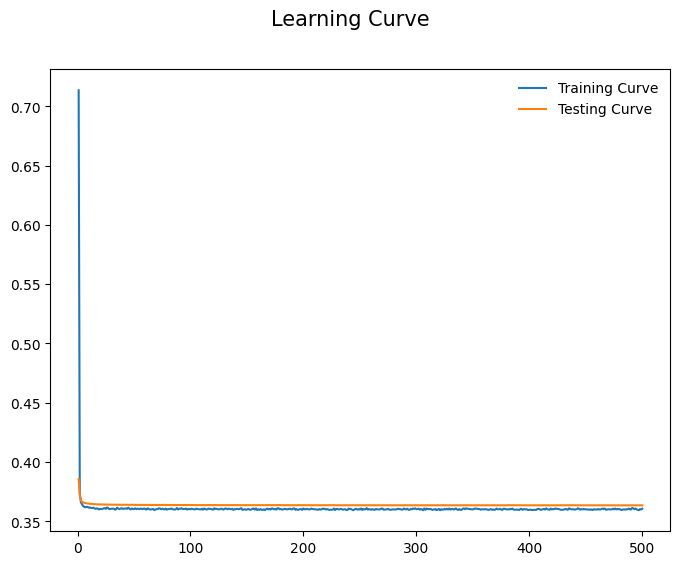

In [10]:
import matplotlib.pyplot as plt
x = [i for i in range(1,501)]
fig, ax = plt.subplots(1, figsize=(8,6))
fig.suptitle("Learning Curve", fontsize = 15)
ax.plot(x, train_loss, label="Training Curve")
ax.plot(x, test_loss, label="Testing Curve")
plt.legend(loc="upper right", frameon=False)
plt.show()

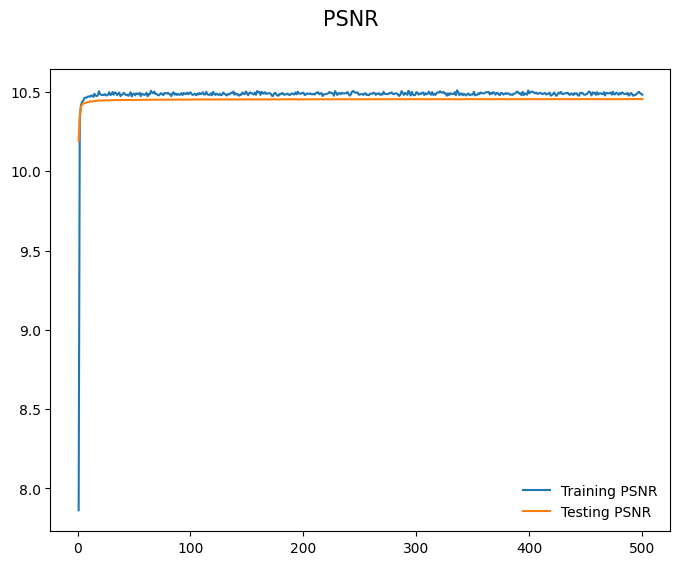

In [11]:
import matplotlib.pyplot as plt
x = [i for i in range(1,501)]
fig, ax = plt.subplots(1, figsize=(8,6))
fig.suptitle("PSNR", fontsize = 15)
ax.plot(x, train_psnr, label="Training PSNR")
ax.plot(x, test_psnr, label="Testing PSNR")
plt.legend(loc="lower right", frameon=False)
plt.show()

In [12]:
print("Train_loss:",train_loss[len(train_loss)-1])
print("Test_loss:",test_loss[len(test_loss)-1])

Train_loss: 0.36071231045636787
Test_loss: 0.3635314697569067


In [13]:
torch.save(model.state_dict(),'encoder_cnn_256.pth')